In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid


import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.manifold import TSNE

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
learning_rate = 3e-4
batch_size = 512

In [4]:
class ResidualBlock(nn.Module):
  def __init__(self, in_ch, hidden, out_ch):
    super().__init__()
    self.block = nn.Sequential(
      nn.Conv2d(in_ch, hidden, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(hidden),
      nn.ReLU(inplace=True),
      nn.Conv2d(hidden, out_ch, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(out_ch),
    )
    self.relu = nn.ReLU(inplace=True)

  def forward(self, x):
    residual = x
    out = self.block(x)
    out += residual
    out = self.relu(out)
    return out

class Encoder(nn.Module):
  def __init__(self, in_ch, d):
    super().__init__()
    self.initial_conv = nn.Sequential(
      nn.Conv2d(in_channels=in_ch, out_channels=32, kernel_size=4, stride=2, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
    )
    self.residual_blocks = nn.Sequential(
      ResidualBlock(64, 64, 64),
      ResidualBlock(64, 64, 64)
    )
    self.final_conv = nn.Conv2d(64, d, kernel_size=3, stride=1, padding=1)

  def forward(self, x):
    x = self.initial_conv(x)
    x = self.residual_blocks(x)
    x = self.final_conv(x)
    return x

class Decoder(nn.Module):
  def __init__(self, in_ch, d):
    super(Decoder, self).__init__()
    self.initial_conv = nn.ConvTranspose2d(d, 64, kernel_size=3, stride=1, padding=1)
    self.residual_blocks = nn.Sequential(
      ResidualBlock(64, 64, 64),
      ResidualBlock(64, 64, 64)
    )
    self.final_deconv_layers = nn.Sequential(
      nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.ConvTranspose2d(32, in_ch, kernel_size=4, stride=2, padding=1),
    )

  def forward(self, x):
    x = self.initial_conv(x)
    x = self.residual_blocks(x)
    x = self.final_deconv_layers(x)
    return x

class VectorQuantizer(nn.Module):
  def __init__(self, k, d):
    ''' k: number of embedding, d: number of dimension of each embedding '''
    super().__init__()
    self.k = k
    self.d = d
    self.embs = nn.Embedding(k, d)
    nn.init.uniform_(
        self.embs.weight.data, -1.0 / np.sqrt(self.d), 1.0 / np.sqrt(self.d)
    )

  def forward(self, z, beta=0.25):
    z = z.permute(0, 2, 3, 1).contiguous()
    flat_z = z.reshape(-1, self.d)

    sim = flat_z @ self.embs.weight.t()
    distances = (
      torch.sum(flat_z**2, dim=1, keepdim=True)
        + torch.sum(self.embs.weight**2, dim=1)
        - 2 * sim
    )

    min_encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
    min_encodings = torch.zeros(
        min_encoding_indices.shape[0], self.k).to(device)
    min_encodings.scatter_(1, min_encoding_indices, 1)

    z_q = (min_encodings @ self.embs.weight).view(z.shape)
    commitment_loss = ((z - z_q.detach()) ** 2).mean()
    codebook_loss = ((z.detach() - z_q) ** 2).mean()

    z_q = z + (z_q - z).detach() # straight-through estimator
    z_q = z_q.permute(0, 3, 1, 2).contiguous()

    return z_q, commitment_loss + beta * codebook_loss

class VQVAE(nn.Module):
  def __init__(self, in_ch, k, d):
    super().__init__()
    self.enc = Encoder(in_ch, d)
    self.vq = VectorQuantizer(k, d)
    self.dec = Decoder(in_ch, d)

  def forward(self, x, lmbda = 1.):
    z = self.enc(x)
    z_q, vq_loss = self.vq(z)
    x_hat = self.dec(z_q)
    rec_loss = ((x - x_hat) ** 2).mean()
    loss = vq_loss + (lmbda * rec_loss)
    return x_hat, loss

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
vq_vae = VQVAE(in_ch=3, k=256, d=64).to(device)
optim = torch.optim.Adam(vq_vae.parameters(), lr=learning_rate)

train_losses = []
test_losses = []

for e in range(25):
    vq_vae.train()
    running_loss = 0.0
    with tqdm(train_dataloader, desc=f"Epoch {e+1} Training") as pbar:
        for i, (x, _) in enumerate(pbar):
            x = x.to(device)
            _, loss = vq_vae(x)

            optim.zero_grad(set_to_none=True)
            loss.backward()
            optim.step()

            loss_value = loss.item()
            running_loss += loss_value
            train_losses.append(loss_value)

            if (i + 1) % 10 == 0:
                pbar.set_description(f"Epoch {e+1} Training - Loss: {running_loss / (i + 1):.4f}")

    running_loss = 0.0
    vq_vae.eval()
    with torch.no_grad(), tqdm(test_dataloader, desc=f"Epoch {e+1} Testing") as pbar:
        for i, (x, _) in enumerate(pbar):
            x = x.to(device)
            _, loss = vq_vae(x, lmbda=1.0)
            loss_value = loss.item()
            running_loss += loss_value
            test_losses.append(loss_value)

            if (i + 1) % 10 == 0:
                pbar.set_description(f"Epoch {e+1} Testing - Loss: {running_loss / (i + 1):.4f}")

Epoch 25 Testing - Loss: 0.0362: 100%|██████████| 20/20 [00:03<00:00,  5.35it/s]


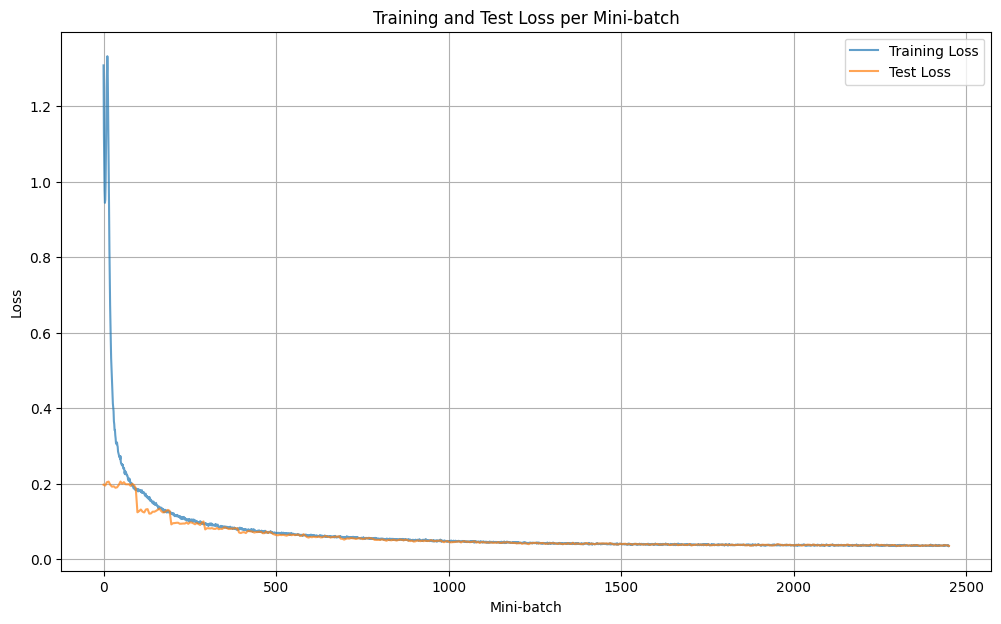

In [7]:
plt.figure(figsize=(12, 7))
plt.plot(train_losses, label='Training Loss', alpha=0.7)
plt.plot(np.linspace(0, len(train_losses), len(test_losses)), test_losses, label='Test Loss', alpha=0.7)
plt.xlabel('Mini-batch')
plt.ylabel('Loss')
plt.title('Training and Test Loss per Mini-batch')
plt.legend()
plt.grid(True)
plt.show()

In [8]:
x = torch.Tensor()
while x.shape[0] < 100:
  x = torch.cat((x, next(iter(test_dataloader))[0]))
x = x.to(device)
x_hat, _ = vq_vae(x)
x, x_hat = x.cpu(), x_hat.cpu()

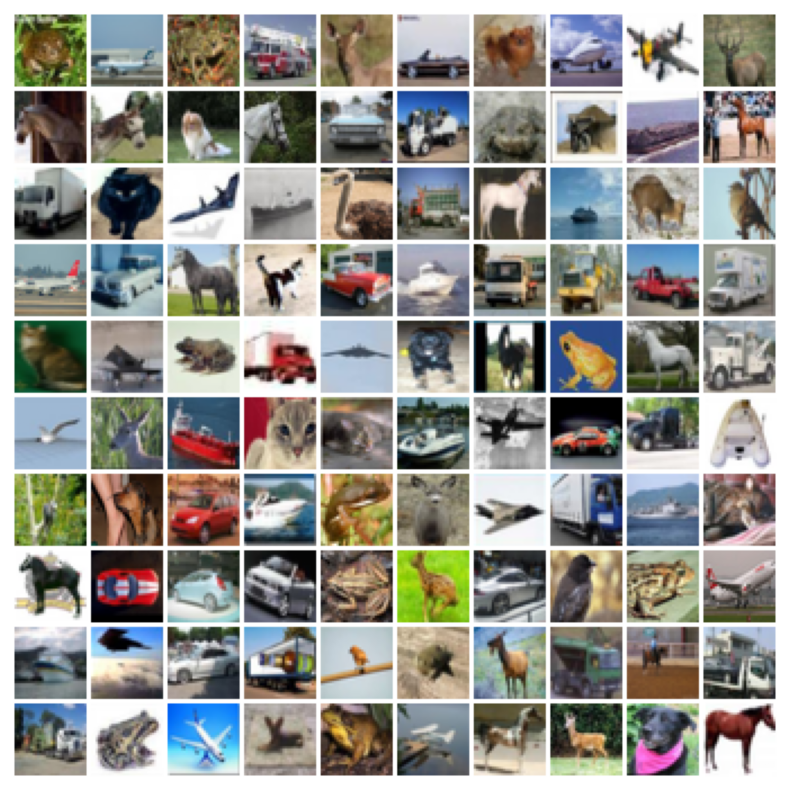

In [9]:
nrow = 10
grid_x = make_grid(x[:100], nrow=nrow, normalize=True, pad_value=1)
plt.figure(figsize=(10, 10))
plt.imshow(grid_x.permute(1, 2, 0))
plt.axis('off')
plt.show()

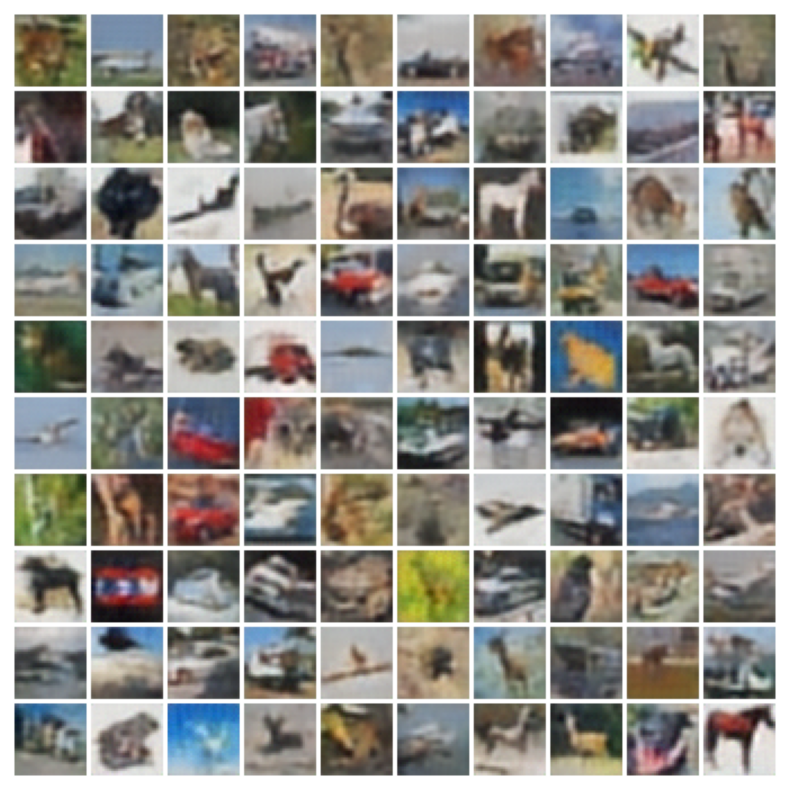

In [10]:
grid_x_hat = make_grid(x_hat[:100], nrow=nrow, normalize=True, pad_value=1)
plt.figure(figsize=(10, 10))
plt.imshow(grid_x_hat.permute(1, 2, 0))
plt.axis('off')
plt.show()

In [11]:
embeddings = vq_vae.vq.embs.weight.data.cpu().numpy()
tsne = TSNE(n_components=2, verbose=1, perplexity=min(30, embeddings.shape[0] - 1), n_iter=300).fit_transform(embeddings)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 256 samples in 0.001s...
[t-SNE] Computed neighbors for 256 samples in 0.042s...
[t-SNE] Computed conditional probabilities for sample 256 / 256
[t-SNE] Mean sigma: 0.263838
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.560013
[t-SNE] KL divergence after 300 iterations: 1.112866


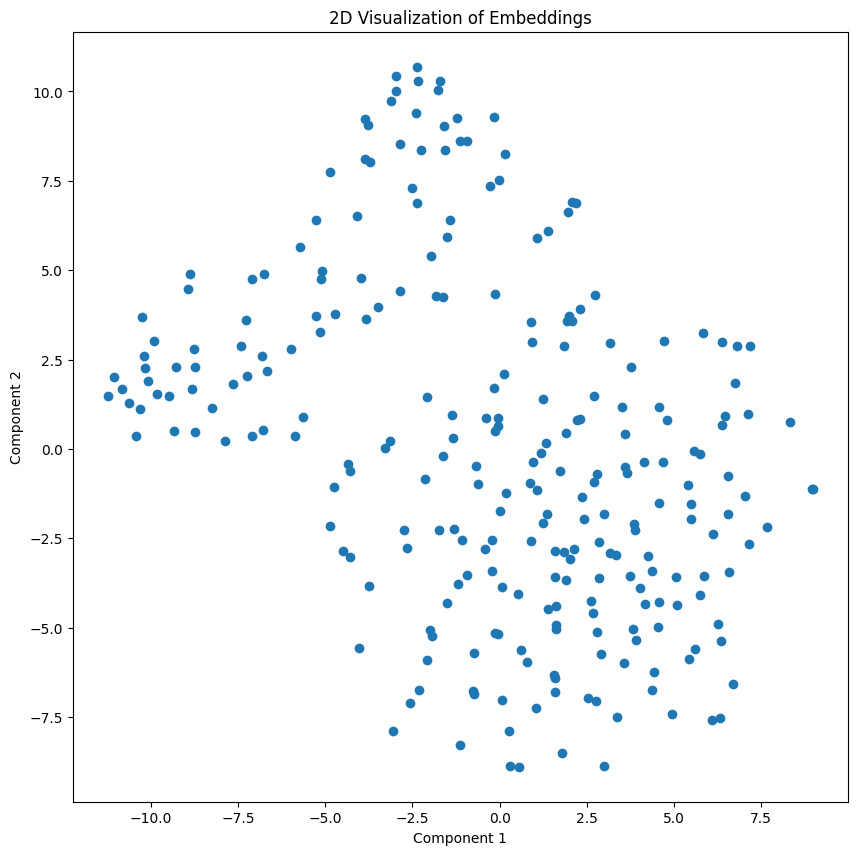

In [12]:
plt.figure(figsize=(10, 10))
plt.scatter(tsne[:, 0], tsne[:, 1])
plt.title('2D Visualization of Embeddings')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()